### DataSet : Amazon Fine Food Reviews 

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q]How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.
<br>

* The dataset is available in two forms
   1. csv file
   2.SQLite Database
    
* We can use any one of the form to load data

In [1]:
# importing required modules for data processing, data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data using pandas
initial_data = pd.read_csv('Reviews.csv')
print("Shape of Data:\t",initial_data.shape)  # print dimensions of data i.e number of rows and columns 

initial_data['Score'].value_counts()

Shape of Data:	 (568454, 10)


5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [3]:
# Filter out data points which Score equal to 3 because they are neither +ve or -ve
initial_data = initial_data[initial_data['Score'] != 3]
print("Shape of Data after filtering which has score equal to 3: ",initial_data.shape)  # print dimensions of data 

# convert type of Score features to string 1) if 1<=Score<= 2 then 0 2) if 4<=Score<=5 then 1
'''
    1 indicates it is postive review
    0 indicates it is negative review
'''
def convert(value):
    if value >= 4:
        return 1
    return 0

actual_data = initial_data.Score
converted_data = actual_data.map(convert)
initial_data['Score'] = converted_data

initial_data.shape

Shape of Data after filtering which has score equal to 3:  (525814, 10)


(525814, 10)

##### Data Cleaning: Deduplication

We need remove if there are any duplicate entries in order to get unbiased results for the analysis of the data.

In [4]:
# Sorting data according to ProductId in ascending order
sorted_data=initial_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Deduplication of entries
staging_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(staging_data.shape)

staging_data=staging_data[staging_data.HelpfulnessNumerator<=staging_data.HelpfulnessDenominator]
print(staging_data.shape)

# How many positive and negative reviews are present in our dataset?
staging_data['Score'].value_counts()

(364173, 10)
(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [5]:
# sort the data according to time
staging_data=staging_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#### Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
# import required modules
import re   # regular expression module used for pattern matching 
import string
import nltk  # natural language processing tool kit for text processing
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) # set of stopwords
sno = nltk.stem.SnowballStemmer('english') # initialising the snowball stemmer

# function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

# function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

# Code for implementing step-by-step the checks mentioned in the pre-processing phase
str1=' '
preprocessed_string=[]
for sent in staging_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)    # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) # final string of cleaned words
    preprocessed_string.append(str1)

In [7]:
# Adding a column of CleanedText which displays the data after pre-processing of the review 
staging_data['CleanedText'] = preprocessed_string 

# To verify first few rows
staging_data[['Text','CleanedText']].head()

,Text,CleanedText
150523,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
150500,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
451855,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
374358,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
451854,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


###### Machine Learning is all about math. For any Machine Learning model to work, we have to convert features which is having text to something(Vector) that an algorithm can use.

* There are lot of methods available to convert to text to vector. 
        1) Bag of words
        2) TF-IDF (term frequency–inverse document frequency)
        
* For Naive Bayes, we can't use avg word2vec and tf-idf w2v because in these words are interrelated where naive bayes assumes      features are independent(Conditional Independence)


##### Bag of words approach

We have class called CountVectorizer in scikit. Following is the syntax of constructor

class sklearn.feature_extraction.text.CountVectorizer(input=’content’, encoding=’utf-8’, decode_error=’strict’, strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=’(?u)\b\w\w+\b’, ngram_range=(1, 1), analyzer=’word’, max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=class ‘numpy.int64’ )

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [8]:
# import required module
from sklearn.feature_extraction.text import CountVectorizer

countVec_model = CountVectorizer(binary=True)
finalCounts = countVec_model.fit_transform(staging_data['CleanedText'].values)

print(type(finalCounts))
print(finalCounts.get_shape())

features = countVec_model.get_feature_names()
print(type(features))
features[500:505]

<class 'scipy.sparse.csr.csr_matrix'>
(364171, 71624)
<class 'list'>


['acquarium', 'acquerello', 'acquies', 'acquiesc', 'acquint']

In [9]:
dataset = finalCounts
labels = staging_data['Score']

In [11]:
# split the data set into train and test
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(dataset, labels, test_size=0.3, random_state=0)

print("Shape of dataset and lables : ",(dataset.shape,labels.shape))

print("Shape of X and y:  ",(X_train.shape,y_train.shape))

print("Shape of X and y:  ",(X_test.shape,y_test.shape))

print("Type of X_train and y_train : ",(type(X_train),type(y_train)))

Shape of dataset and lables :  ((364171, 71624), (364171,))
Shape of X and y:   ((254919, 71624), (254919,))
Shape of X and y:   ((109252, 71624), (109252,))
Type of X_train and y_train :  (<class 'scipy.sparse.csr.csr_matrix'>, <class 'pandas.core.series.Series'>)


In [45]:
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score

# create a set of alpha values
alpha_values = list(range(1,11))

# list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for a in alpha_values:
    nb = BernoulliNB(alpha = a)
    scores = cross_val_score(nb, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal alpha value is : %d' % optimal_alpha)


print("The misclassification error for each alpha value is : ", np.round(MSE,3))


The optimal alpha value is : 1
The misclassification error for each alpha value is :  [0.12 0.12 0.13 0.13 0.14 0.14 0.15 0.15 0.15 0.15]


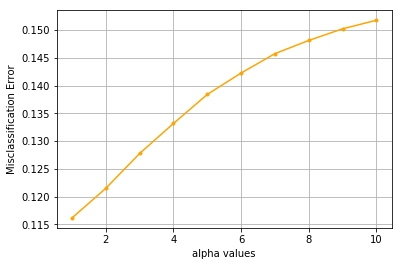

In [46]:
plt.plot(alpha_values,MSE,marker=".",color="orange")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("alpha values")
plt.grid()
plt.show()

In [47]:
from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
nb_optimal = BernoulliNB(alpha = optimal_alpha)

# fitting the model
nb_optimal.fit(X_train, y_train)

# predict the response
pred = nb_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100

print('\nThe accuracy of the NB classifier for k = %d is %f%%' % (optimal_alpha, acc))


The accuracy of the NB classifier for k = 1 is 88.368176%


#### Conclusion :  Accuaracy of Naive Bayes Classifier using Bag of words with hyper parameter alpha = 1 is 88.368176 %

In [48]:
import collections
print("Actual Values: ",collections.Counter(y_test))
print("Predicted Values: ",collections.Counter(pred))

Actual Values:  Counter({1: 92039, 0: 17213})
Predicted Values:  Counter({1: 93681, 0: 15571})


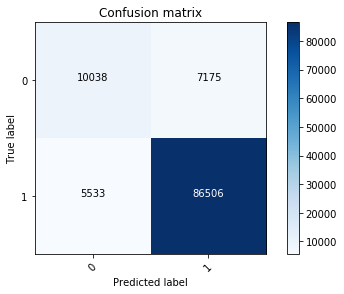

In [49]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
labels = [0, 1]
confusion_matrix_values = confusion_matrix(y_test, pred,labels = labels)

np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix_values, classes = labels)



In [50]:
tn, fp, fn, tp = confusion_matrix_values.ravel()
print('True Negative(tn) : ',tn)
print('False Positive(fp): ',fp)
print('False Negative(fn) : ',fn)
print('True Positive(tp) : ',tp)

# Print the TPR , TNR, FPR, FNR
TPR = tp/(tp+fn)
print('True Positive Rate : ',TPR)
TNR = tn/(tn+fp)
print('True Negative Rate : ',TNR)
FPR = fp/(tn+fp)
print('False Positive Rate : ',FPR)
FNR = fn/(tp+fn)
print('False Negative Rate : ',FNR)

True Negative(tn) :  10038
False Positive(fp):  7175
False Negative(fn) :  5533
True Positive(tp) :  86506
True Positive Rate :  0.9398841795325894
True Negative Rate :  0.5831638877592518
False Positive Rate :  0.4168361122407483
False Negative Rate :  0.060115820467410555


##### Observations:

* Out of 92,039 postive reviews,classifier predicted 86506 positive reviews correctly.
* Out of 17213 negative reviews,classifier predicted 10038 negative reviews correctly.
* classifier predicted 5533 reviews as negative, but actually they are positive reviews.
* classifier predicted 7175 reviews as positive, but actually they are negative reviews.


#### Feature Importance 

In [51]:
neg_class_prob_sorted = nb_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb_optimal.feature_log_prob_[1, :].argsort()
print(neg_class_prob_sorted)
print(pos_class_prob_sorted)
print('Top negative words \n',np.take(countVec_model.get_feature_names(), neg_class_prob_sorted[:10]))
print('Top positive words \n',np.take(countVec_model.get_feature_names(), pos_class_prob_sorted[:10]))

[    0 42443 42445 ... 49522 35959 62026]
[35811 18182 18180 ... 36800 62026 35959]
Top negative words 
 ['aa' 'niaspan' 'nibbi' 'nibbley' 'nibblin' 'niblet' 'nic' 'nicarauguan'
 'nicc' 'niceah']
Top positive words 
 ['lici' 'dogfoodadvis' 'dogfish' 'dogfind' 'dogadan' 'premiss' 'premius'
 'premonit' 'preoocupi' 'premeium']


#### Precision_Score, Recall_Score and f1_score

In [52]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('precision_score: ',precision_score(y_test, pred,pos_label=1))
print('recall_score: ',recall_score(y_test, pred,pos_label=1))
f1 = f1_score(y_test, pred,pos_label=1)
print("fl_score: ",f1)


precision_score:  0.9234102966449974
recall_score:  0.9398841795325894
fl_score:  0.9315744130949816


#### Observations:
* We can see that, we have got high precision score, that means, our classifier predicted one few of positive reviews as negative.
* Also we have got the high recall score, out classifier predicted most the reviews are positive which are positive in actual.
* As precision and recall score is high , f1_score will also high because it harmonic mean of both.


#### TF-IDF (term frequency–inverse document frequency):

In [23]:
# import required modules
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vectors_tf_idf = tf_idf_vect.fit_transform(staging_data['CleanedText'].values)

print("Type of vectors: ",type(vectors_tf_idf))
print("Shape : ",vectors_tf_idf.get_shape())

features = tf_idf_vect.get_feature_names()
print("\n",features[:20]) # get first 20 features


labels = staging_data['Score']
dataset = vectors_tf_idf   # Actual data

Type of vectors:  <class 'scipy.sparse.csr.csr_matrix'>
Shape :  (364171, 2923725)

 ['aa', 'aa pleas', 'aa state', 'aaa', 'aaa aaa', 'aaa class', 'aaa condit', 'aaa dont', 'aaa hockey', 'aaa job', 'aaa magazin', 'aaa perfect', 'aaa plus', 'aaa rate', 'aaa spelt', 'aaa tue', 'aaaa', 'aaaaa', 'aaaaa kid', 'aaaaa start']


In [24]:
# split data into train and test data set

X_train,X_test,y_train,y_test = cross_validation.train_test_split(dataset,labels,test_size = 0.3,random_state = 0)

print("Shape of dataset and lables : ",(dataset.shape,labels.shape))

print("Shape of X and y:  ",(X_train.shape,y_train.shape))

print("Shape of X and y:  ",(X_test.shape,y_test.shape))

print("Type of X_train and y_train : ",(type(X_train),type(y_train)))

Shape of dataset and lables :  ((364171, 2923725), (364171,))
Shape of X and y:   ((254919, 2923725), (254919,))
Shape of X and y:   ((109252, 2923725), (109252,))
Type of X_train and y_train :  (<class 'scipy.sparse.csr.csr_matrix'>, <class 'pandas.core.series.Series'>)


In [26]:
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score

# create a set of alpha values
alpha_values = list(range(1,11))

# list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for a in alpha_values:
    nb = BernoulliNB(alpha = a)
    scores = cross_val_score(nb, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal alpha value is : %d' % optimal_alpha)


print("The misclassification error for each alpha value is : ", np.round(MSE,3))


The optimal alpha value is : 10
The misclassification error for each alpha value is :  [0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16]


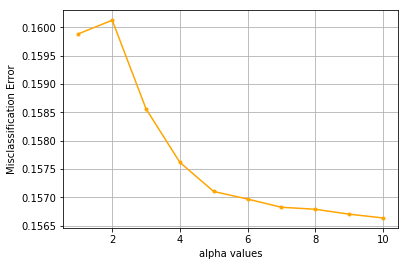

In [27]:
plt.plot(alpha_values,MSE,marker=".",color="orange")  # first list is for x axis and second list is for y axis
plt.ylabel("Misclassification Error")
plt.xlabel("alpha values")
plt.grid()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score
# instantiate learning model k = optimal_k
nb_optimal = BernoulliNB(alpha = optimal_alpha)

# fitting the model
nb_optimal.fit(X_train, y_train)

# predict the response
pred = nb_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100

print('\nThe accuracy of the NB classifier for k = %d is %f%%' % (optimal_alpha, acc))


The accuracy of the NB classifier for k = 10 is 84.228206%


#### Conclusion :  Accuaracy of Naive Bayes Classifier using tf-idf with hyper parameter alpha = 10 is 84.228206 %

In [29]:
import collections
print("Actual Values: ",collections.Counter(y_test))
print("Predicted Values: ",collections.Counter(pred))

Actual Values:  Counter({1: 92039, 0: 17213})
Predicted Values:  Counter({1: 109210, 0: 42})


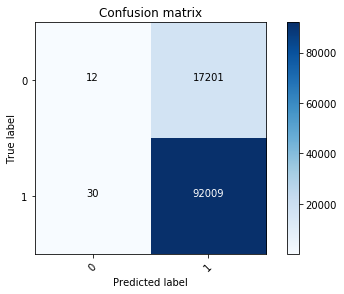

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
labels = [0, 1]
confusion_matrix_values = confusion_matrix(y_test, pred,labels = labels)

np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix_values, classes = labels)


In [31]:
tn, fp, fn, tp = confusion_matrix_values.ravel()
print('True Negative(tn) : ',tn)
print('False Positive(fp): ',fp)
print('False Negative(fn) : ',fn)
print('True Positive(tp) : ',tp)


# Print the TPR , TNR, FPR, FNR
TPR = tp/(tp+fn)
print('True Positive Rate : ',TPR)
TNR = tn/(tn+fp)
print('True Negative Rate : ',TNR)
FPR = fp/(tn+fp)
print('False Positive Rate : ',FPR)
FNR = fn/(tp+fn)
print('False Negative Rate : ',FNR)

True Negative(tn) :  12
False Positive(fp):  17201
False Negative(fn) :  30
True Positive(tp) :  92009
True Positive Rate :  0.9996740512174187
True Negative Rate :  0.0006971475047928891
False Positive Rate :  0.9993028524952071
False Negative Rate :  0.0003259487825812971


##### Observations:

* Out of 92,039 postive reviews,classifier predicted 92,009 positive reviews correctly.
* Out of 17213 negative reviews,classifier predicted 12 negative reviews correctly.
* classifier predicted  30 reviews as negative, but actually they are positive reviews.
* classifier predicted 17201 reviews as positive, but actually they are negative reviews.


#### Feature Importance

In [36]:
neg_class_prob_sorted = nb_optimal.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = nb_optimal.feature_log_prob_[1, :].argsort()
print(neg_class_prob_sorted)
print(pos_class_prob_sorted)
print('Top negative words \n',np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print('Top positive words \n',np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:10]))

[      0 1815096 1815098 ... 1986886 1452387 2547230]
[1525160 1243846 2289761 ... 1504390 2547230 1452387]
Top negative words 
 ['aa' 'oyo love' 'oyster age' 'oyster also' 'oyster amazon' 'oyster anyth'
 'oyster bar' 'oyster best' 'oyster bewar' 'oyster big']
Top positive words 
 ['made ident' 'hostess golden' 'show power' 'descript collect' 'show pour'
 'descript combo' 'hostess gave' 'show potenti' 'descript complet'
 'descript compost']


In [40]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print('precision_score: ',precision_score(y_test, pred,pos_label=1))
print('recall_score: ',recall_score(y_test, pred,pos_label=1))
f1 = f1_score(y_test, pred,pos_label=1)
print("fl_score: ",f1)

precision_score:  0.8424961084149803
recall_score:  0.9996740512174187
fl_score:  0.9143796987811119


#### Observations:
* We can see that, we have got almost high precision score, that means, our classifier predicted only few of positive reviews as negative.
* Also we have got the high recall score, out classifier predicted most the reviews are positive which are positive in actual.
* As precision and recall score is high , f1_score will also high because it harmonic mean of both.


#### Final Conclusion:

 * Accuracy is high for bag of words feature extraction compared to tf-idf. 